<a href="https://www.kaggle.com/erfansobhaei/dcgan-for-celeba?scriptVersionId=87252903" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

! pip install -q gdown
import gdown
from zipfile import ZipFile

In [2]:
%%capture
# Original File Link: https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
url = "https://drive.google.com/uc?id=1iXJ0SSuvc0C9jnjlJ0Gy-pUTvbRxy8zg"
output = "data.zip"
gdown.download(url, output, quiet=False)

with ZipFile("./data.zip", "r") as zipobj:
    zipobj.extractall()

In [3]:
image_size = (64, 64)
batch_size = 32

dataset = keras.preprocessing.image_dataset_from_directory(
    "img_align_celeba",
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    seed=42,
)

dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


2022-02-07 23:47:48.934046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 23:47:49.035263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 23:47:49.036313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 23:47:49.039418: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-02-07 23:47:51.930336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


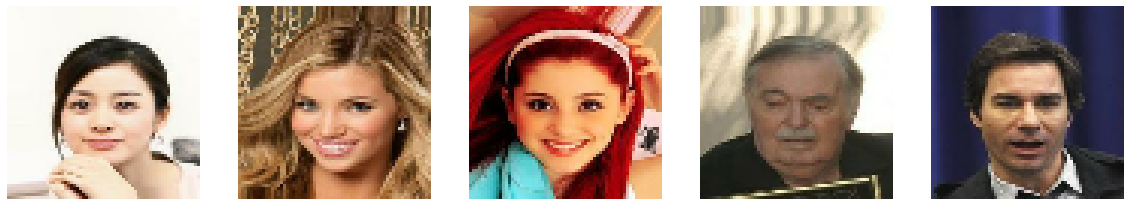

In [4]:
plt.figure(figsize=(20, 5))
for images in dataset.take(1):
    for i in range(5):
        input_shape = images[i].shape
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.axis("off")

In [5]:
discriminator = keras.Sequential([
    keras.Input(input_shape),
    layers.Conv2D(64, (3,3), padding="same", strides=2),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, (3,3), padding="same", strides=2),
    layers.LeakyReLU(0.2),
    layers.Conv2D(256, (3,3), padding="same", strides=2),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
    ], name='Discriminator'
)

discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)           

In [6]:
latent_dim = 128

generator = keras.Sequential([
    keras.Input(latent_dim),
    layers.Dense(np.prod((8, 8, 128))),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, (3,3), padding="same", strides=2),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(256, (3,3), padding="same", strides=2),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(512, (3,3), padding="same", strides=2),
    layers.LeakyReLU(0.2),
    layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ], name="Generator"
)

generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       295168    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       11

In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss = loss
        self.d_loss_metric = keras.metrics.Mean(name="D")
        self.g_loss_metric = keras.metrics.Mean(name="G")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    

    def train_step(self, real_images):
        
        # Generate new images based on random latent vectors
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        
        # Add genrated images to the real images with distinct labels
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to labels
        labels += 0.02 * tf.random.uniform(tf.shape(labels))

        # Train Discriminator based on Generator's output images
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Choose new random latent vectors for training Genrator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Tell Discriminator that all of the images (both real and fake ones) are real
        misleading_labels = tf.zeros((batch_size, 1))

        # Train Generator based on Discriminator's feedback
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update values of loss metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
        

In [8]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images.numpy()
        plt.figure(figsize=(20, 10))
        for i in range(self.num_img):
            plt.subplot(2, self.num_img//2, i+1)
            plt.imshow(generated_images[i])
            plt.axis('off')
        plt.show()
            


Epoch 1/50


2022-02-07 23:47:55.486019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6332/6332 [==============================] - 716s 112ms/step - d_loss: 0.5466 - g_loss: 1.3272


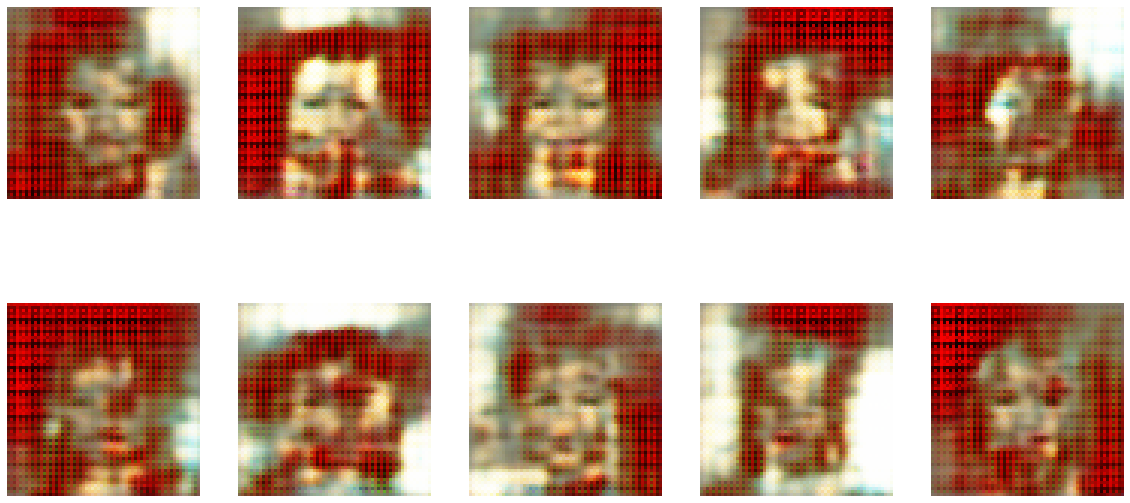

Epoch 2/50
6332/6332 [==============================] - 716s 113ms/step - d_loss: 0.6156 - g_loss: 1.0728


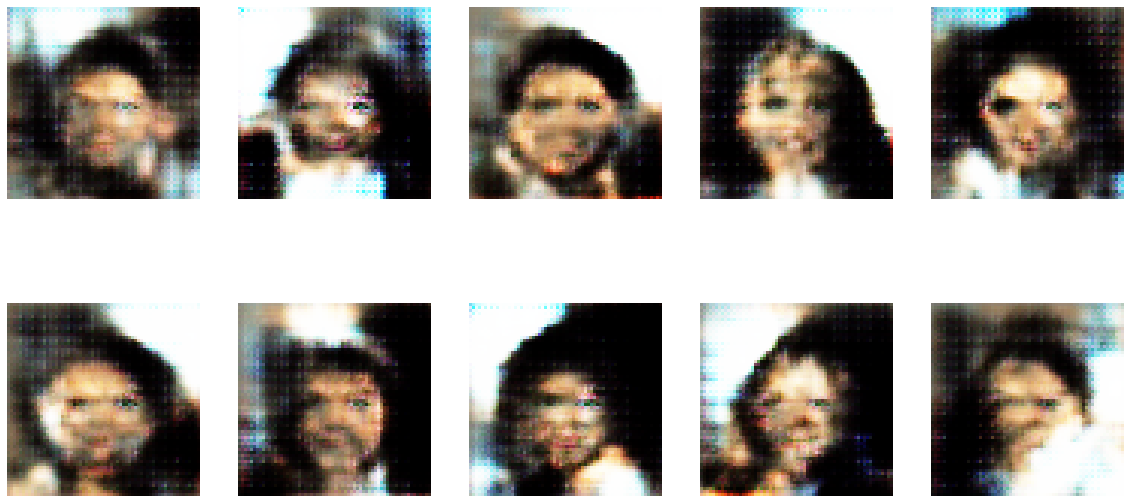

Epoch 3/50
6332/6332 [==============================] - 717s 113ms/step - d_loss: 0.6365 - g_loss: 1.0211


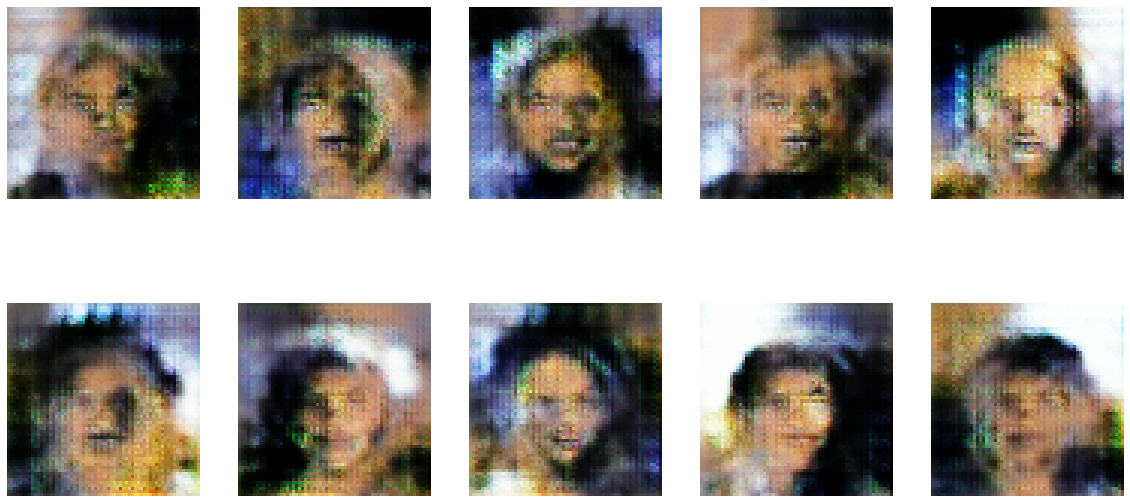

Epoch 4/50
6332/6332 [==============================] - 717s 113ms/step - d_loss: 0.5694 - g_loss: 1.1948


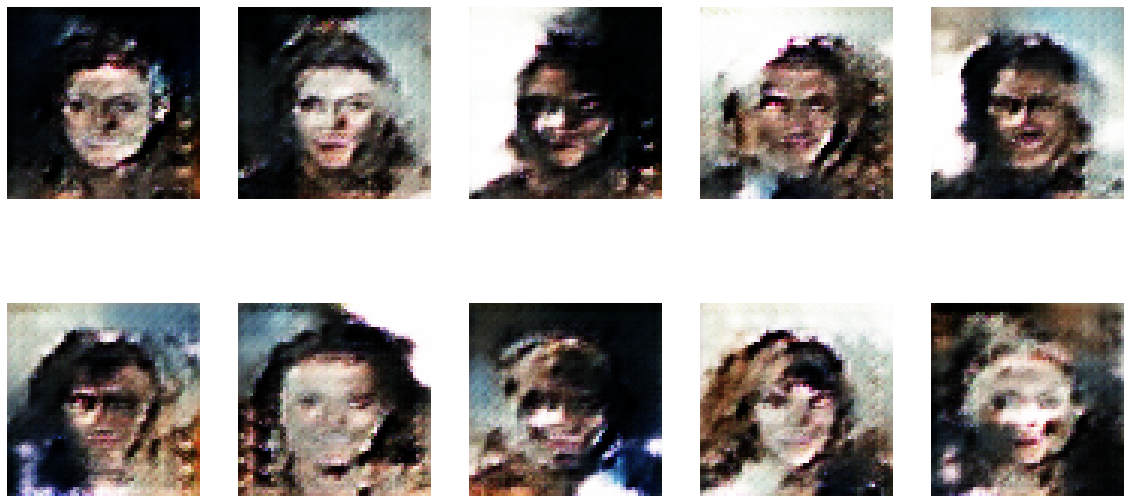

Epoch 5/50
6332/6332 [==============================] - 718s 113ms/step - d_loss: 0.5403 - g_loss: 1.3242


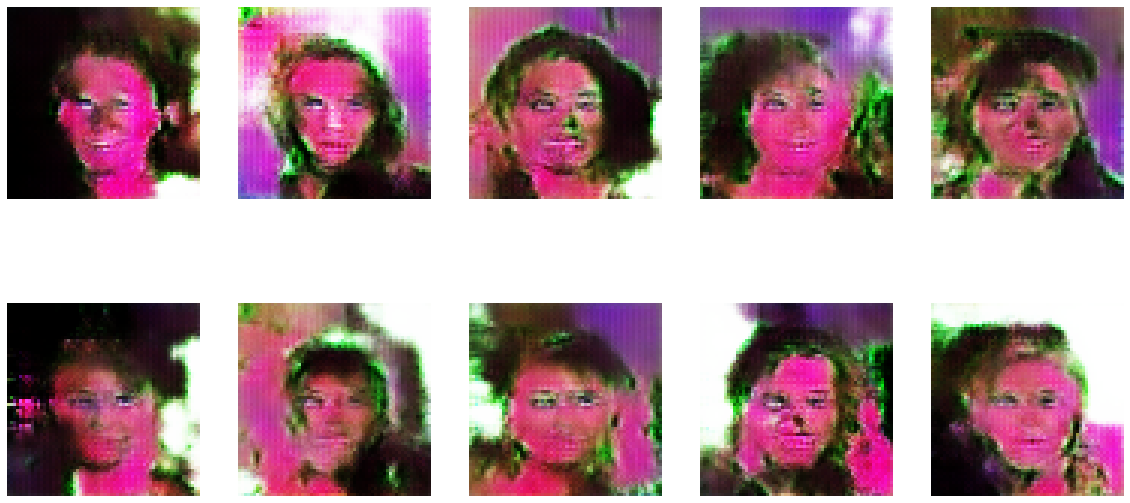

Epoch 6/50
6332/6332 [==============================] - 717s 113ms/step - d_loss: 0.5640 - g_loss: 1.2152


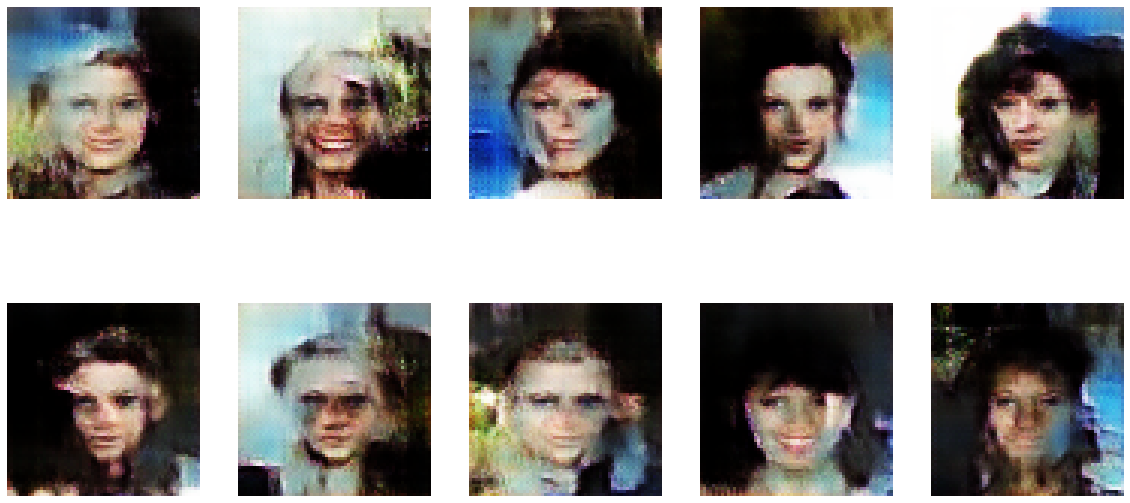

Epoch 7/50
6332/6332 [==============================] - 714s 113ms/step - d_loss: 0.6129 - g_loss: 1.1124


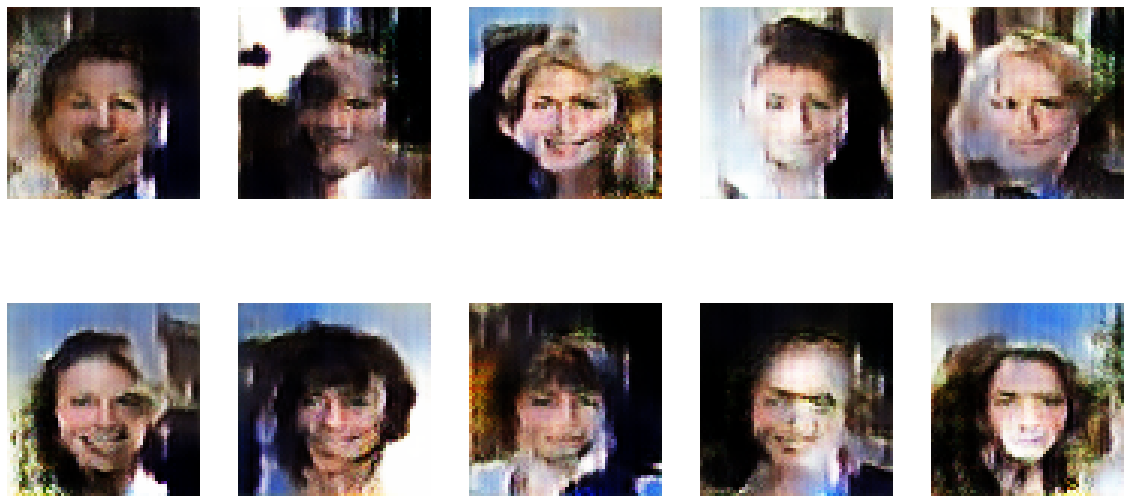

Epoch 8/50
6332/6332 [==============================] - 714s 113ms/step - d_loss: 0.6167 - g_loss: 1.0753


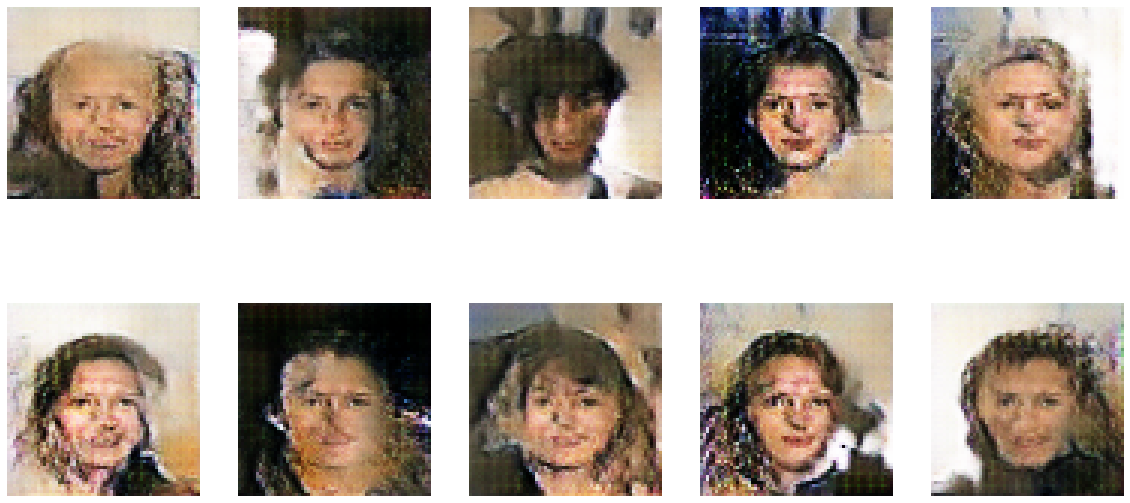

Epoch 9/50
6332/6332 [==============================] - 717s 113ms/step - d_loss: 0.6235 - g_loss: 1.0198


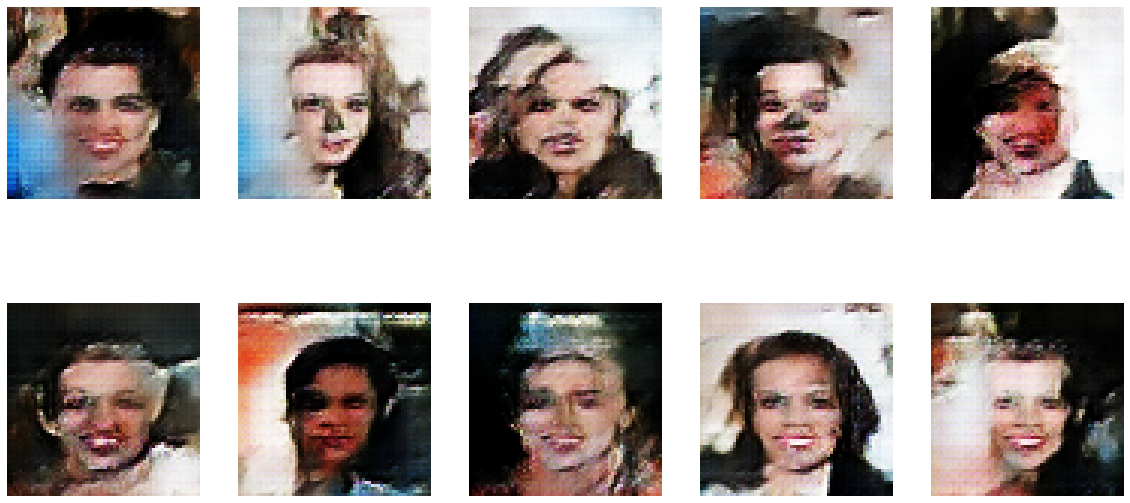

Epoch 10/50
6332/6332 [==============================] - 715s 113ms/step - d_loss: 0.6325 - g_loss: 0.9893


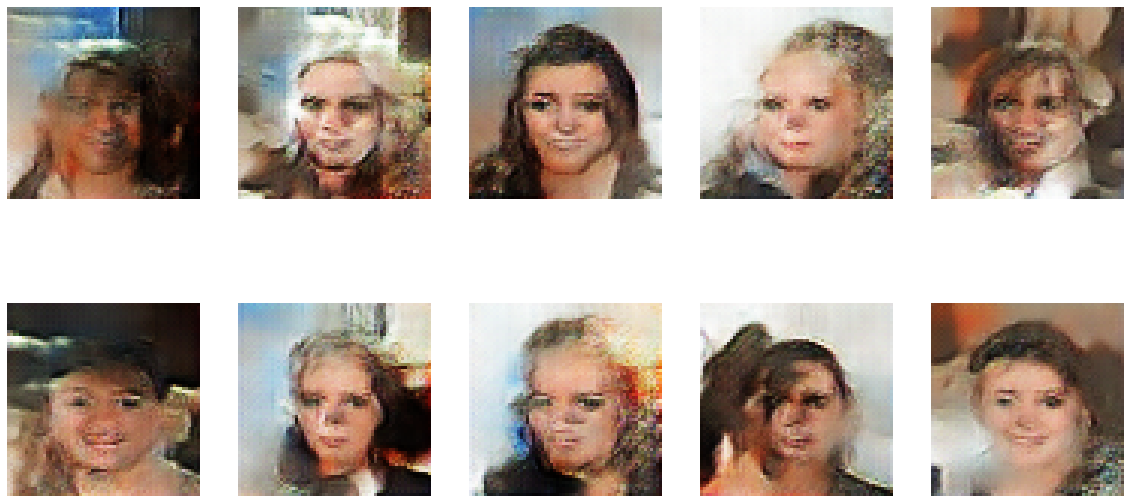

Epoch 11/50
6332/6332 [==============================] - 716s 113ms/step - d_loss: 0.6329 - g_loss: 0.9691


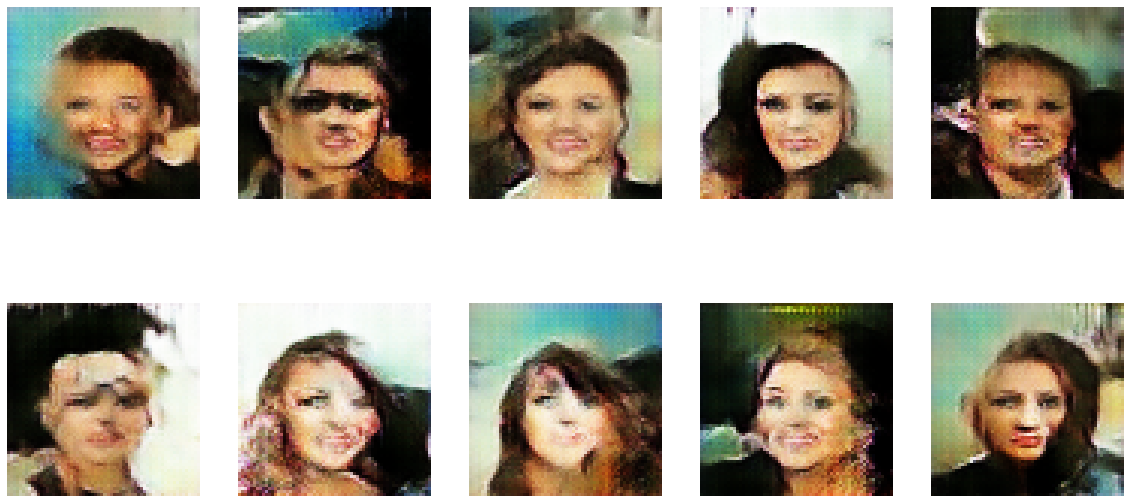

Epoch 12/50
6332/6332 [==============================] - 714s 113ms/step - d_loss: 0.6360 - g_loss: 0.9503


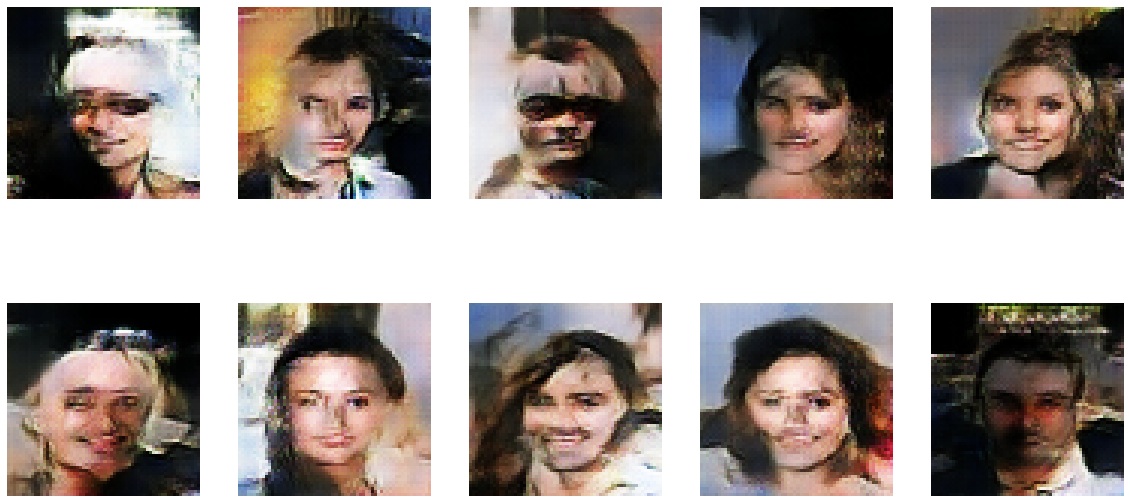

Epoch 13/50
6332/6332 [==============================] - 710s 112ms/step - d_loss: 0.6472 - g_loss: 0.9358


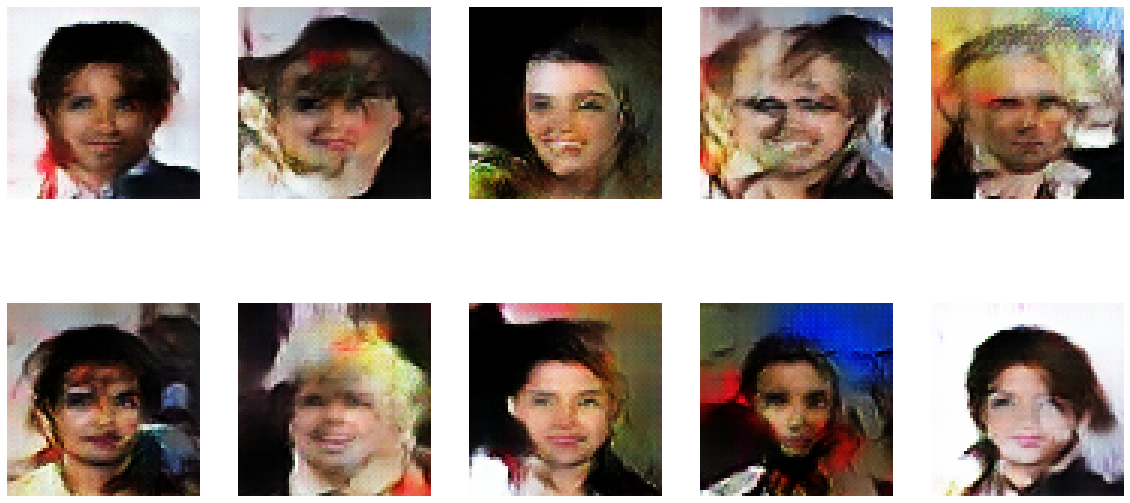

Epoch 14/50
6332/6332 [==============================] - 714s 113ms/step - d_loss: 0.6507 - g_loss: 0.9276


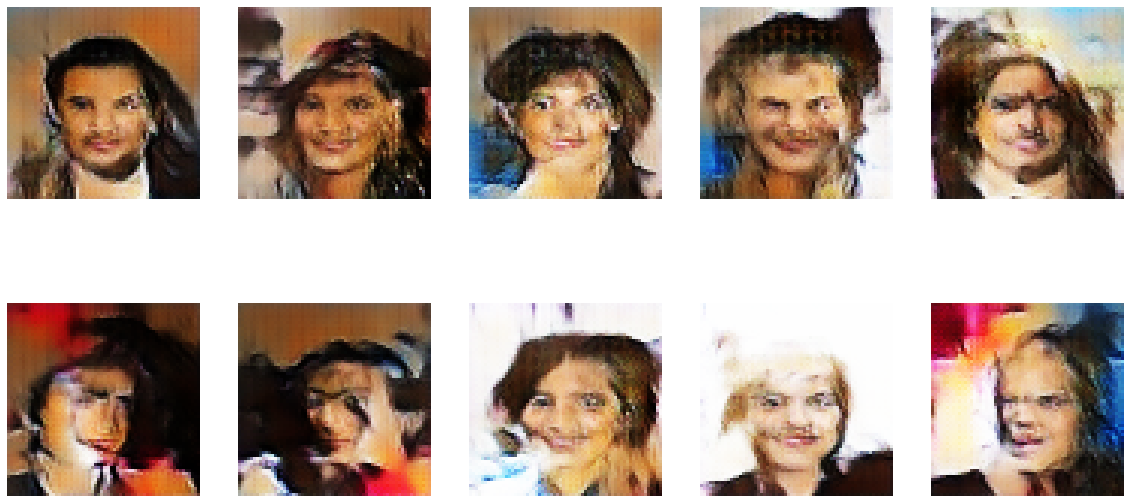

Epoch 15/50
6332/6332 [==============================] - 709s 112ms/step - d_loss: 0.6407 - g_loss: 0.9232


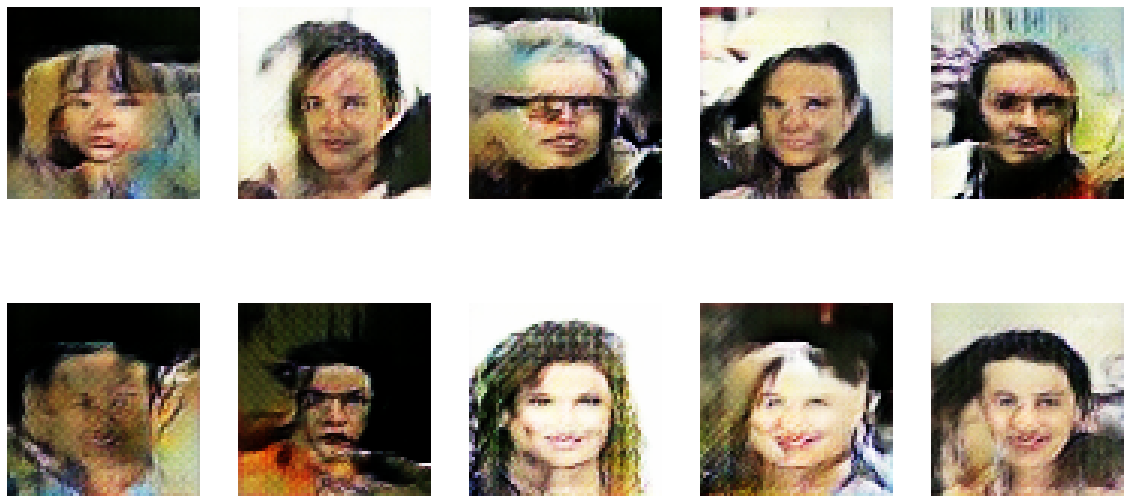

Epoch 16/50
6332/6332 [==============================] - 709s 112ms/step - d_loss: 0.6467 - g_loss: 0.9139


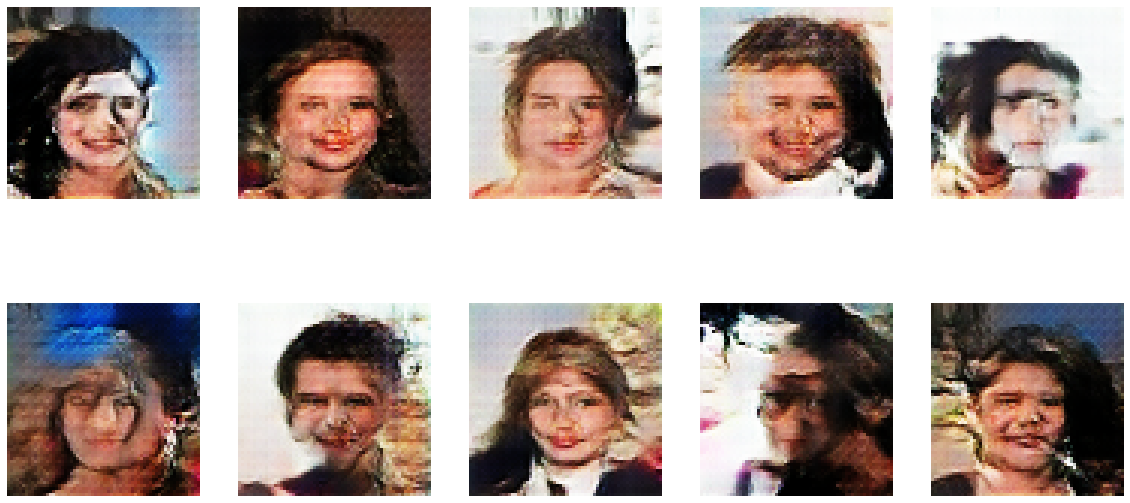

Epoch 17/50
6332/6332 [==============================] - 712s 112ms/step - d_loss: 0.6435 - g_loss: 0.9276


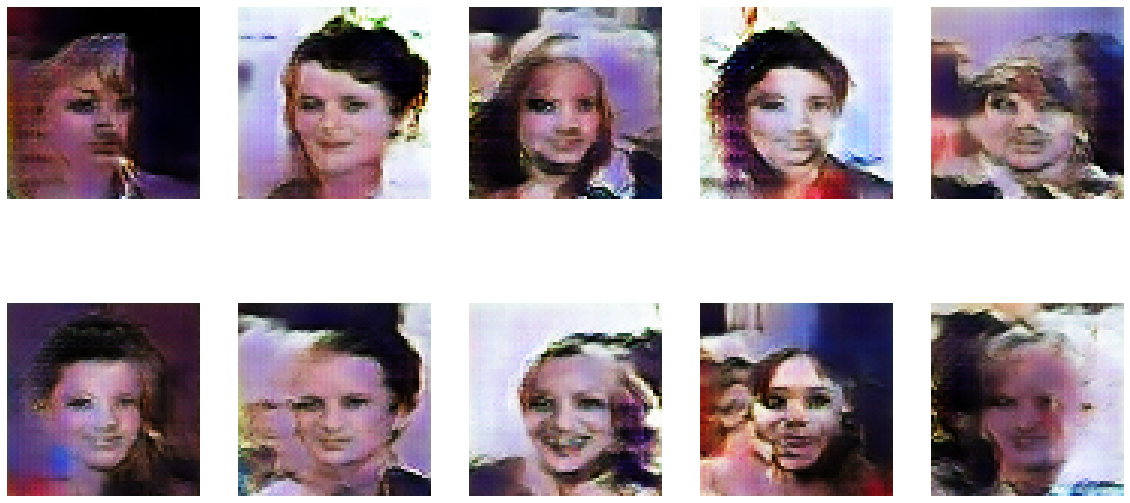

Epoch 18/50
6332/6332 [==============================] - 709s 112ms/step - d_loss: 0.6420 - g_loss: 0.9267


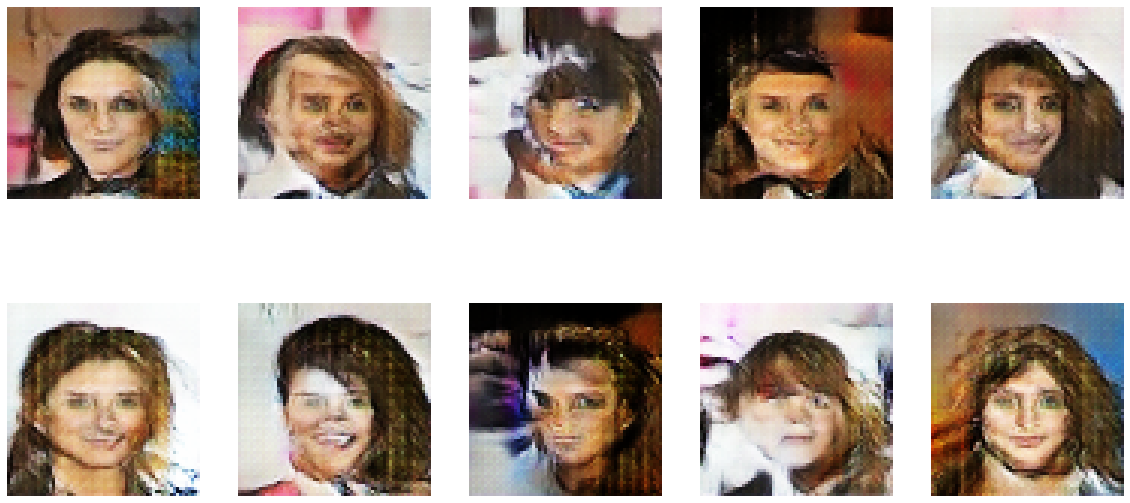

Epoch 19/50
6332/6332 [==============================] - 715s 113ms/step - d_loss: 0.6444 - g_loss: 0.9222


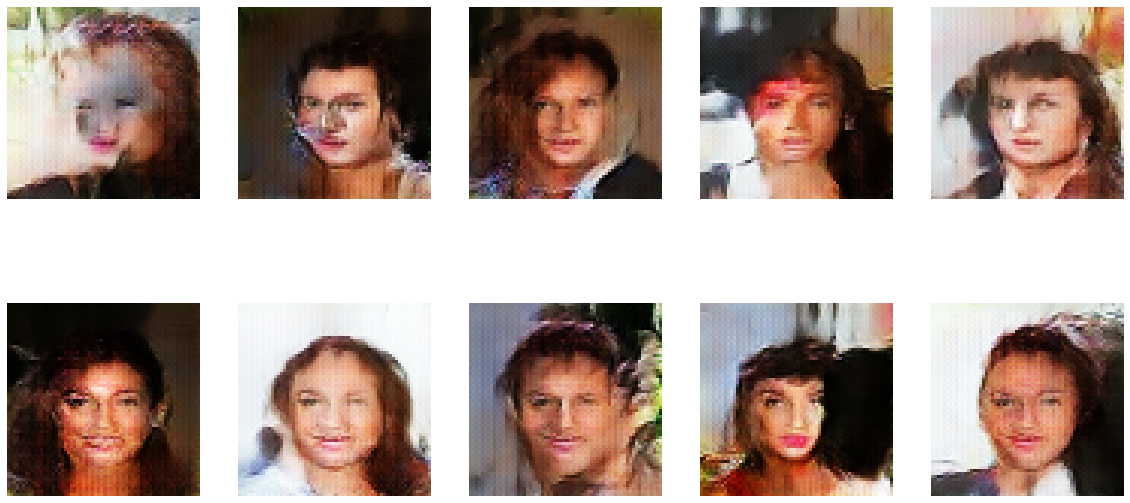

Epoch 20/50
6332/6332 [==============================] - 710s 112ms/step - d_loss: 0.6473 - g_loss: 0.9361


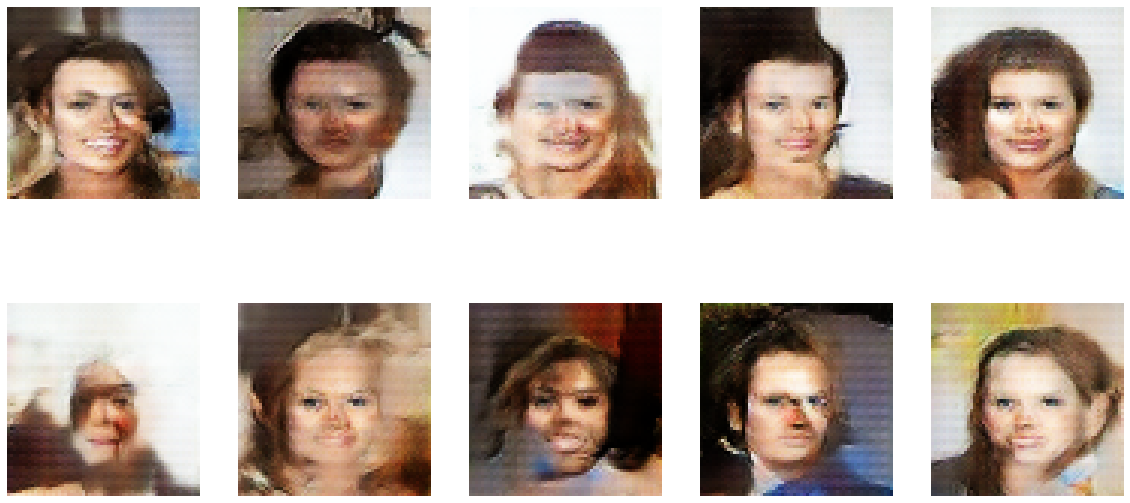

Epoch 21/50
6332/6332 [==============================] - 715s 113ms/step - d_loss: 0.6377 - g_loss: 0.9348


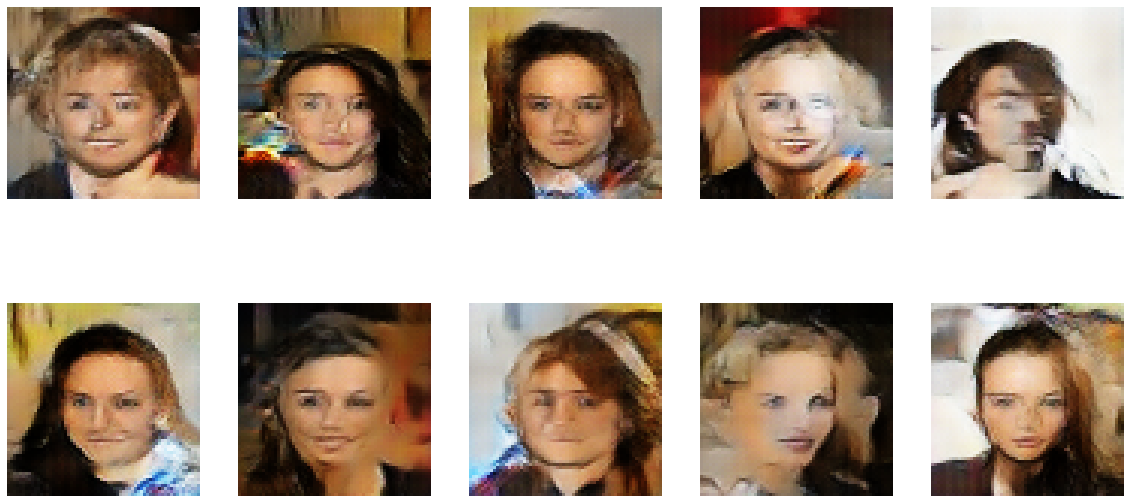

Epoch 22/50
6332/6332 [==============================] - 711s 112ms/step - d_loss: 0.6341 - g_loss: 0.9312


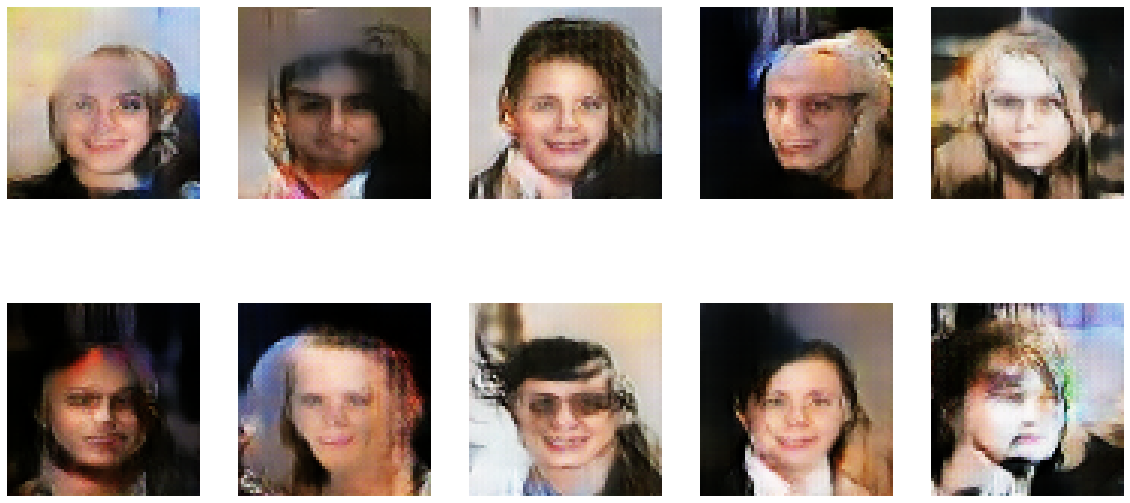

Epoch 23/50
6332/6332 [==============================] - 711s 112ms/step - d_loss: 0.6258 - g_loss: 0.9387


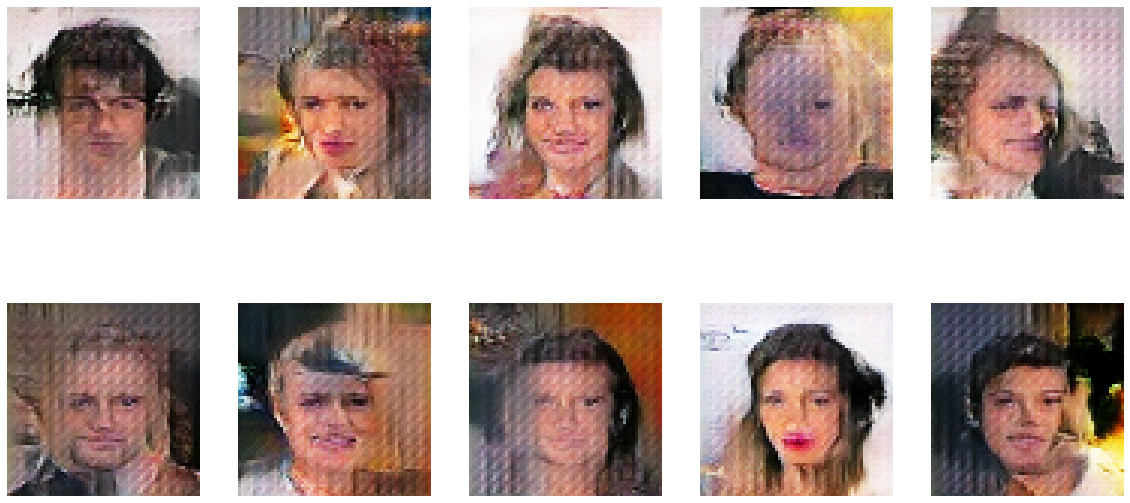

Epoch 24/50
6332/6332 [==============================] - 704s 111ms/step - d_loss: 0.6277 - g_loss: 0.9516


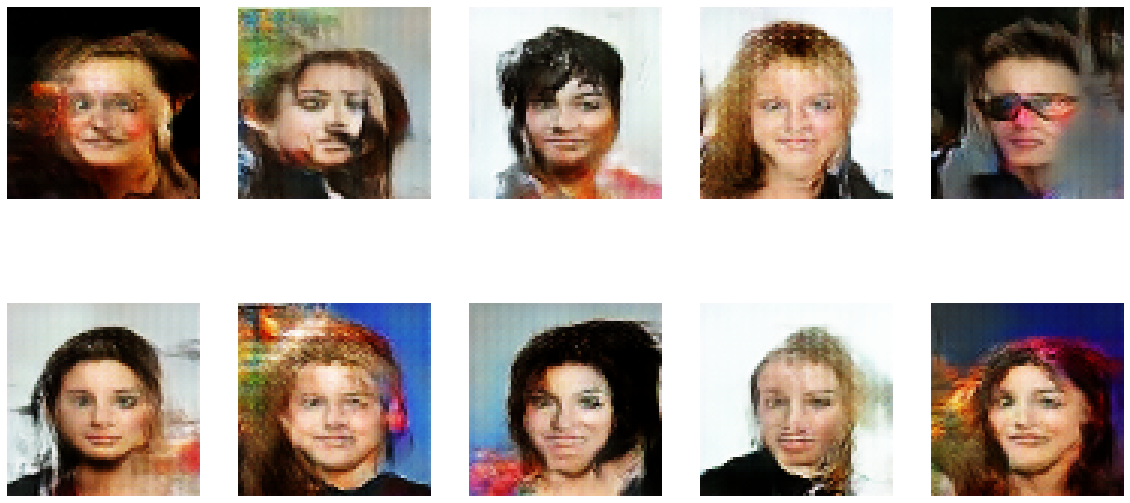

Epoch 25/50
6332/6332 [==============================] - 704s 111ms/step - d_loss: 0.6259 - g_loss: 0.9529


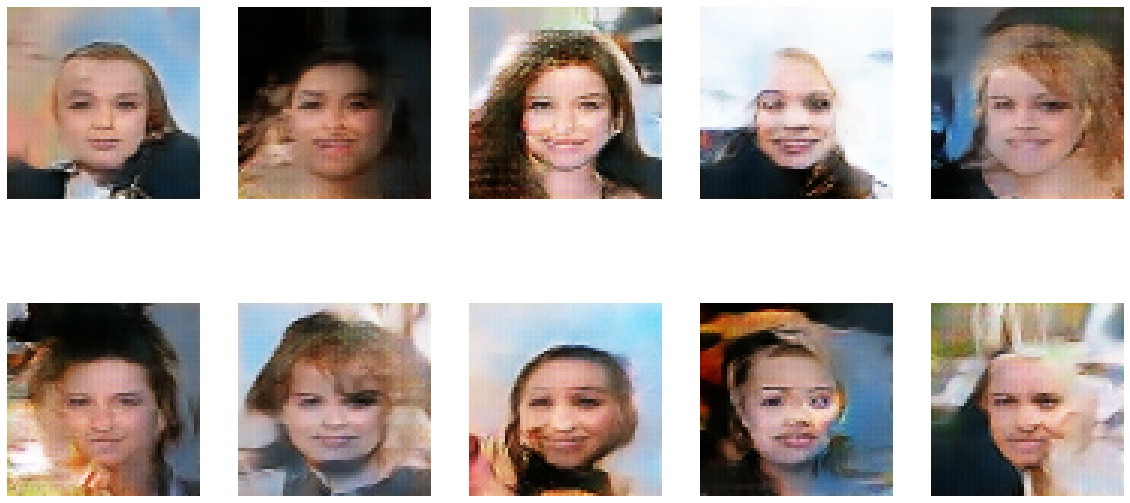

Epoch 26/50
6332/6332 [==============================] - 709s 112ms/step - d_loss: 0.6290 - g_loss: 0.9740


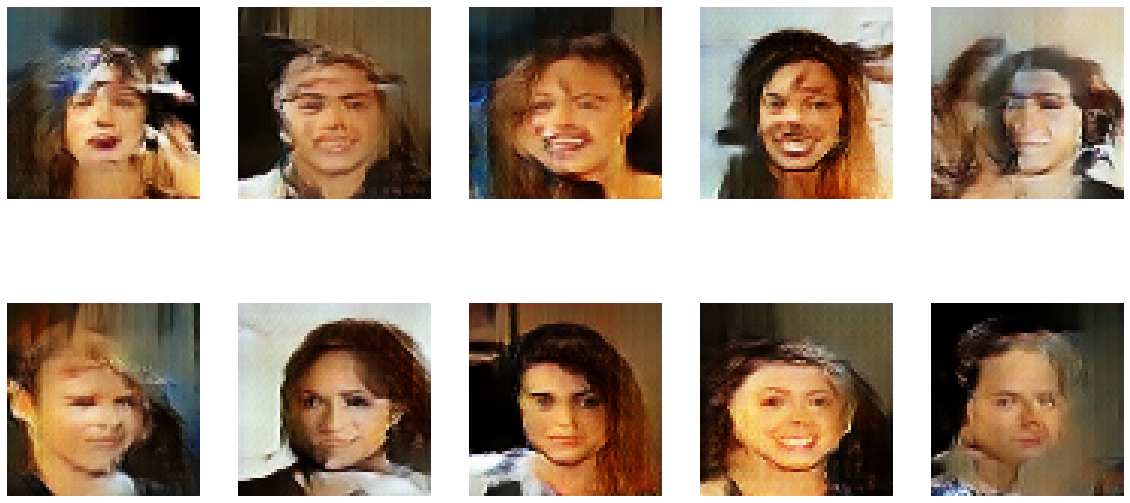

Epoch 27/50
6332/6332 [==============================] - 706s 111ms/step - d_loss: 0.6224 - g_loss: 0.9674


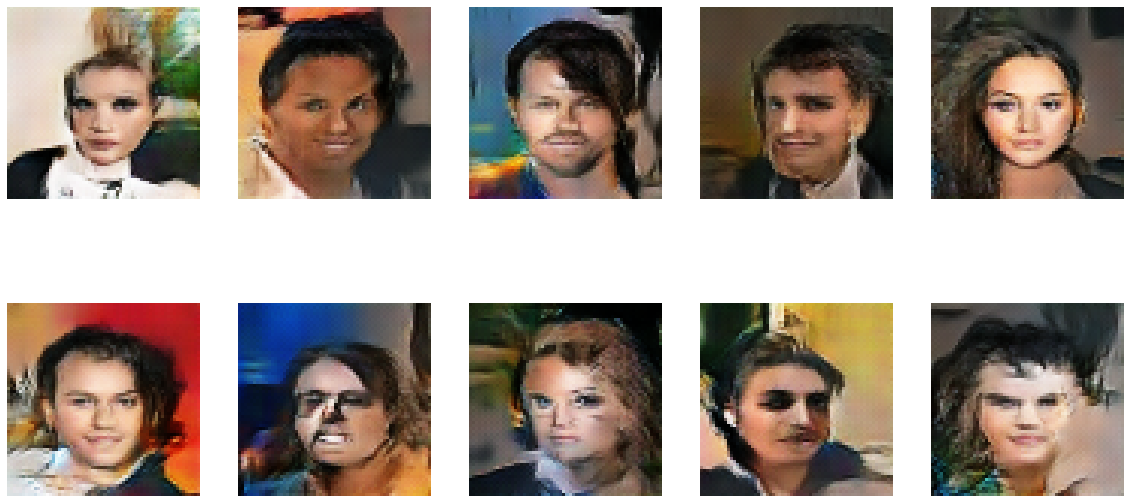

Epoch 28/50
6332/6332 [==============================] - 706s 111ms/step - d_loss: 0.6268 - g_loss: 0.9679


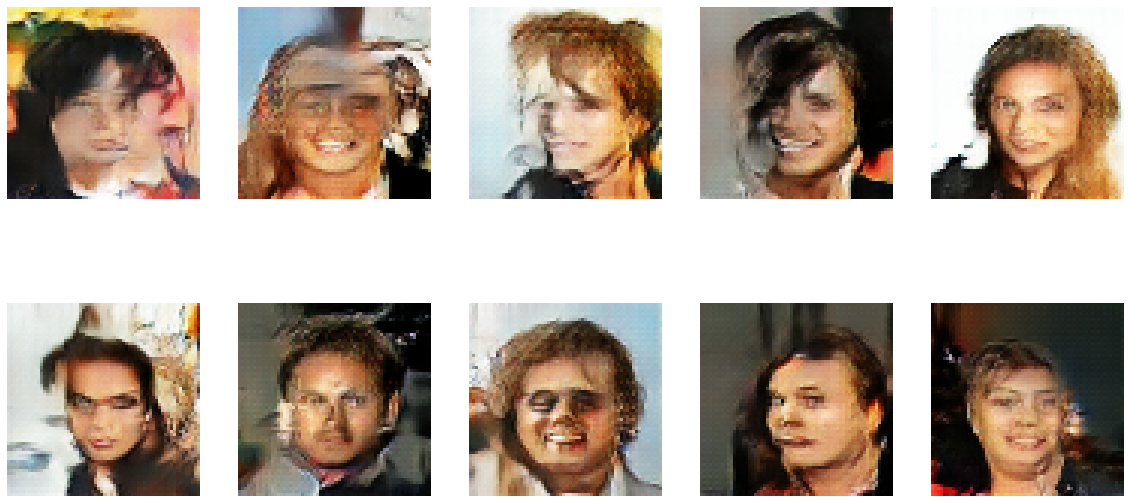

Epoch 29/50
6332/6332 [==============================] - 710s 112ms/step - d_loss: 0.6231 - g_loss: 0.9538


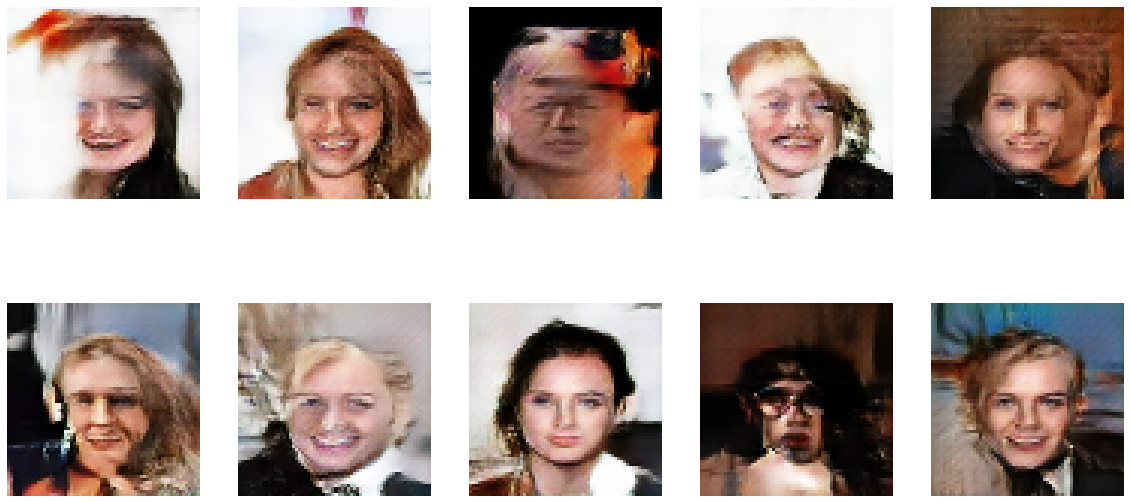

Epoch 30/50
6332/6332 [==============================] - 705s 111ms/step - d_loss: 0.6187 - g_loss: 0.9614


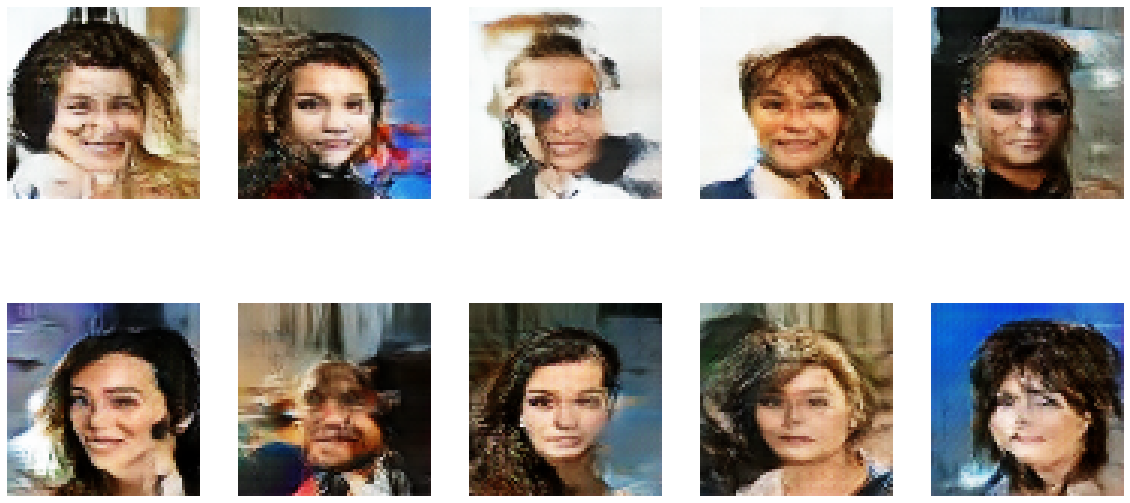

Epoch 31/50
6332/6332 [==============================] - 709s 112ms/step - d_loss: 0.6202 - g_loss: 0.9642


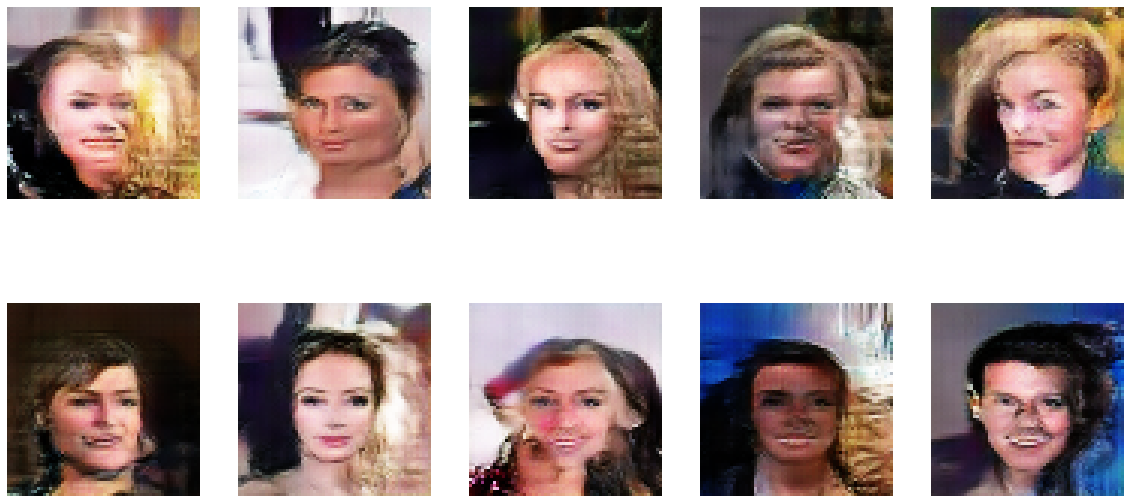

Epoch 32/50
6332/6332 [==============================] - 708s 112ms/step - d_loss: 0.6171 - g_loss: 0.9759


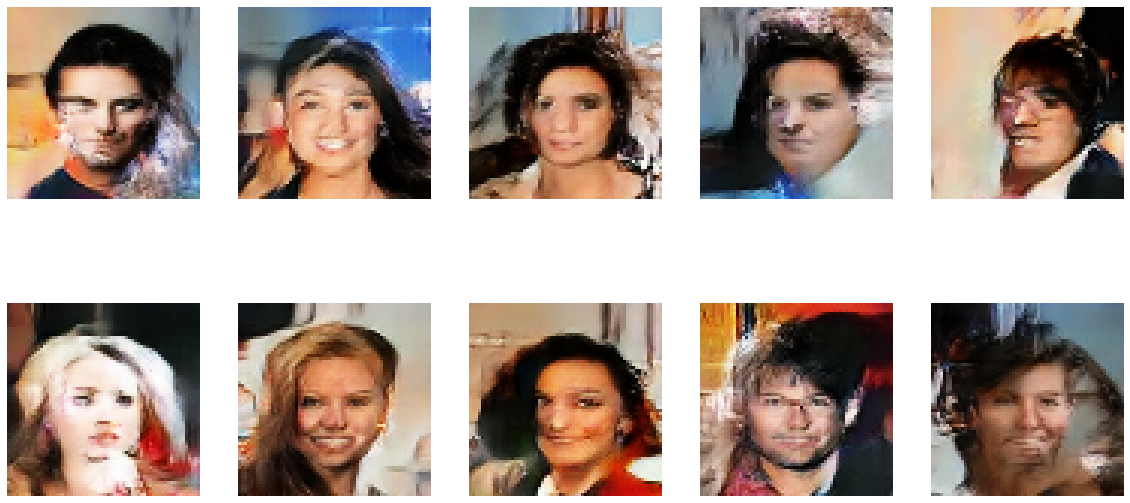

Epoch 33/50
6332/6332 [==============================] - 708s 112ms/step - d_loss: 0.6142 - g_loss: 0.9895


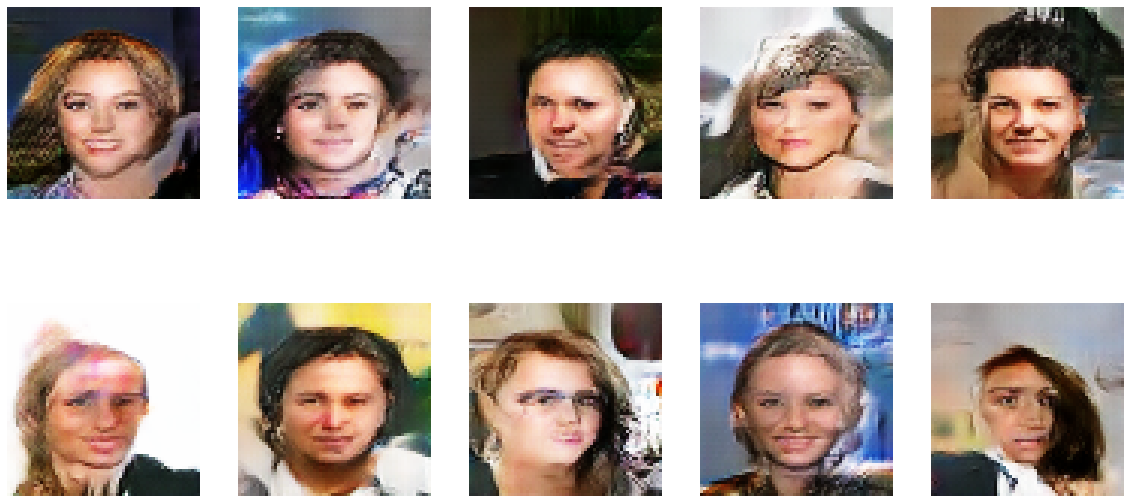

Epoch 34/50
6332/6332 [==============================] - 707s 112ms/step - d_loss: 0.6110 - g_loss: 0.9938


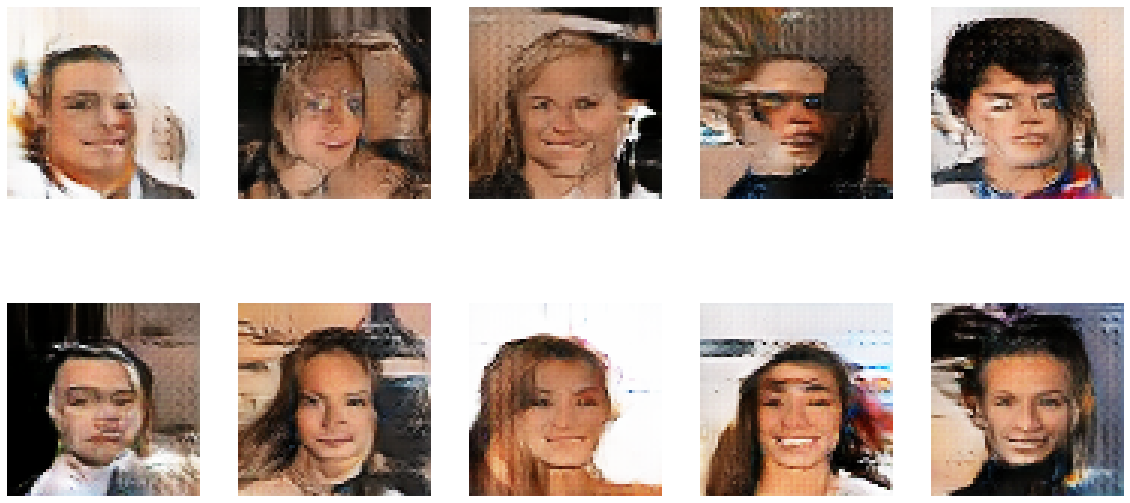

Epoch 35/50
6332/6332 [==============================] - 711s 112ms/step - d_loss: 0.6096 - g_loss: 1.0215


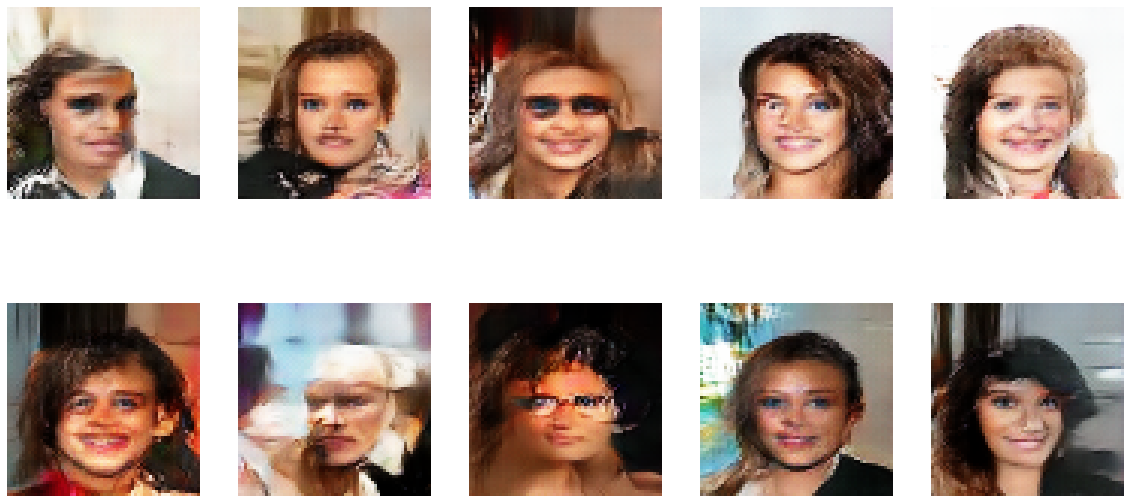

Epoch 36/50
6332/6332 [==============================] - 712s 112ms/step - d_loss: 0.6017 - g_loss: 0.9992


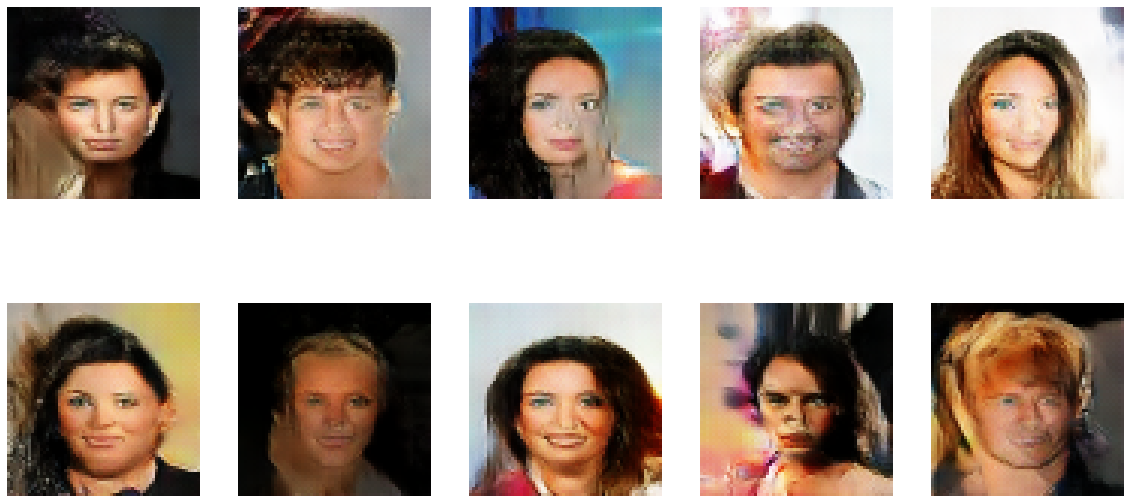

Epoch 37/50
6332/6332 [==============================] - 714s 113ms/step - d_loss: 0.6017 - g_loss: 1.0035


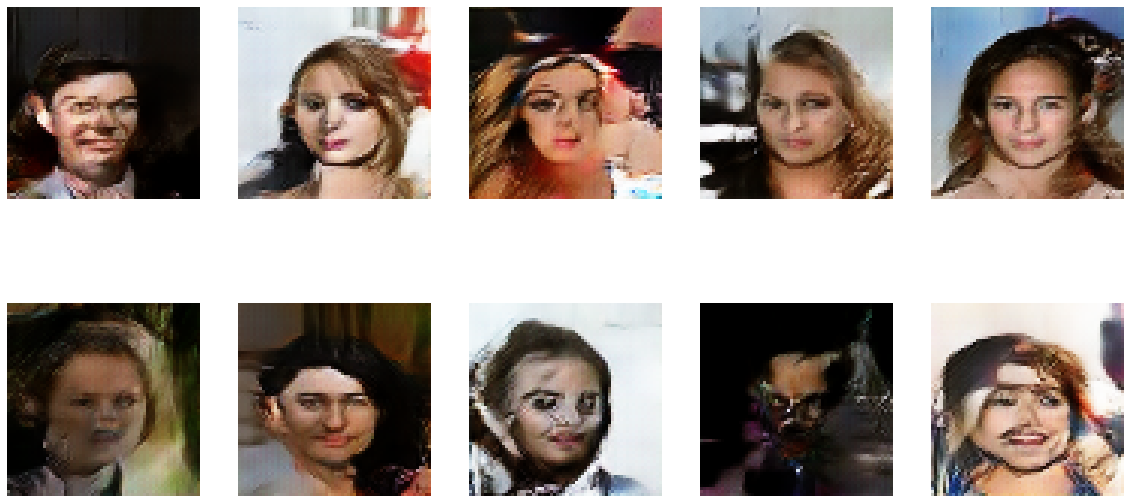

Epoch 38/50
6332/6332 [==============================] - 714s 113ms/step - d_loss: 0.6024 - g_loss: 1.0159


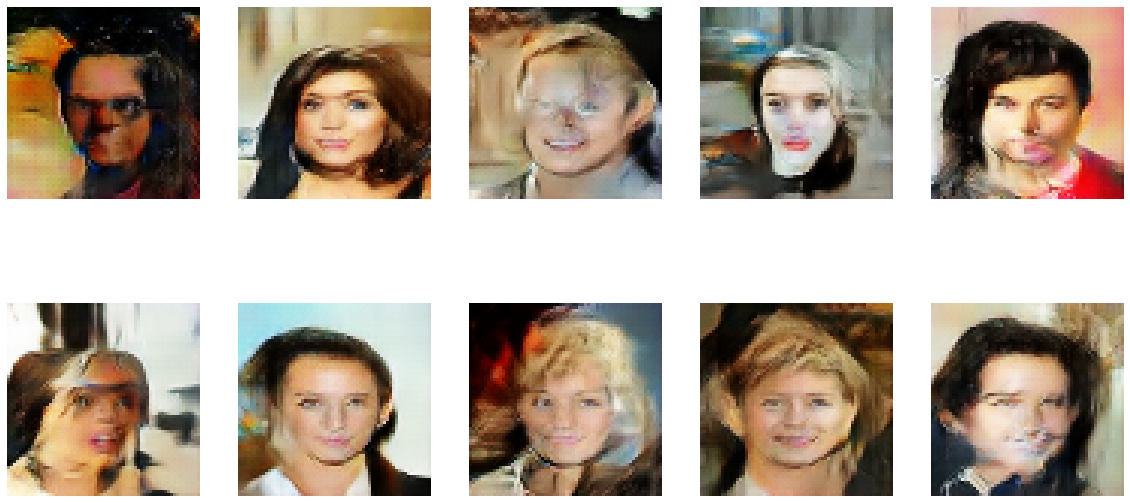

Epoch 39/50
6332/6332 [==============================] - 710s 112ms/step - d_loss: 0.5991 - g_loss: 1.0173


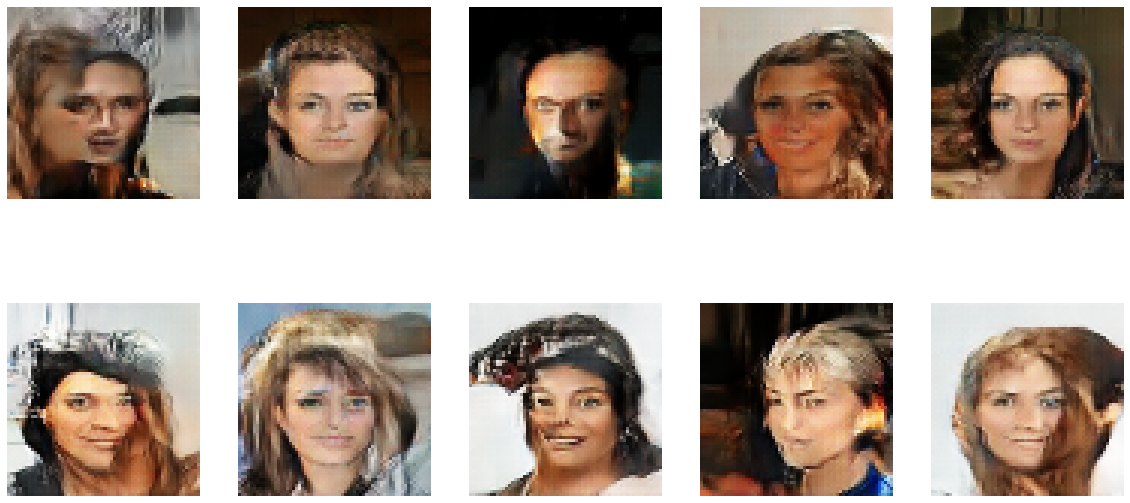

Epoch 40/50
6332/6332 [==============================] - 711s 112ms/step - d_loss: 0.5967 - g_loss: 1.0280


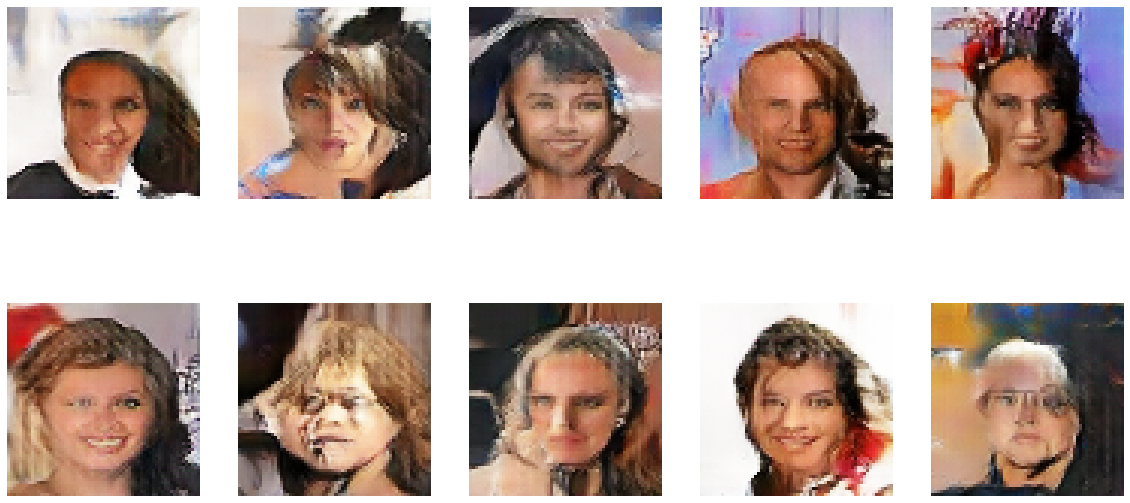

Epoch 41/50
6332/6332 [==============================] - 717s 113ms/step - d_loss: 0.5957 - g_loss: 1.0245


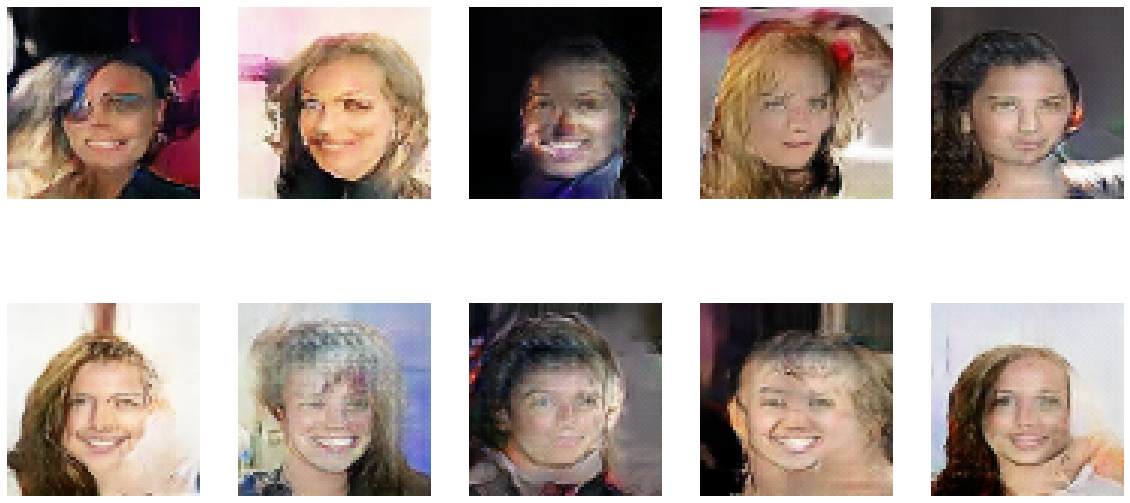

Epoch 42/50
6332/6332 [==============================] - 711s 112ms/step - d_loss: 0.5922 - g_loss: 1.0302


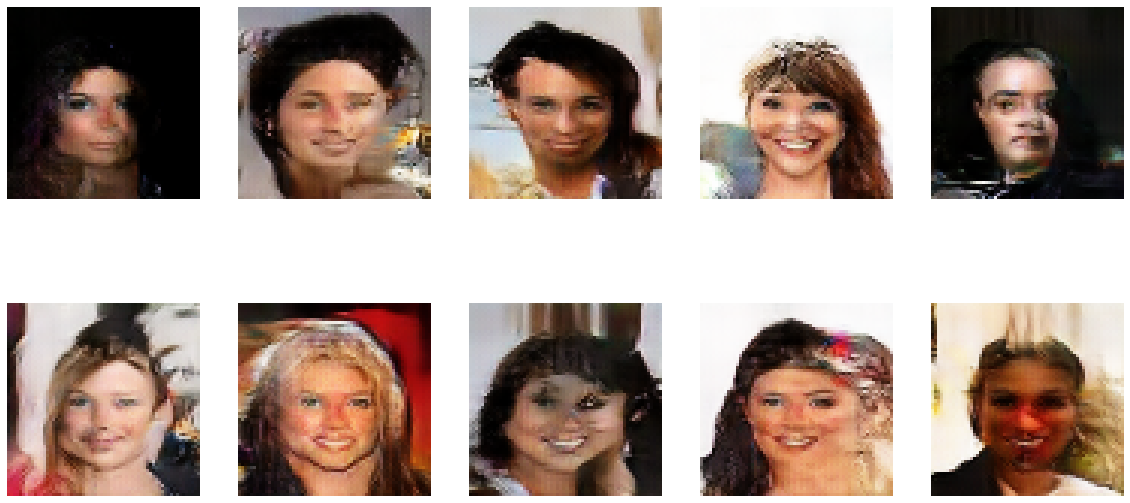

Epoch 43/50
6332/6332 [==============================] - 708s 112ms/step - d_loss: 0.5897 - g_loss: 1.0510


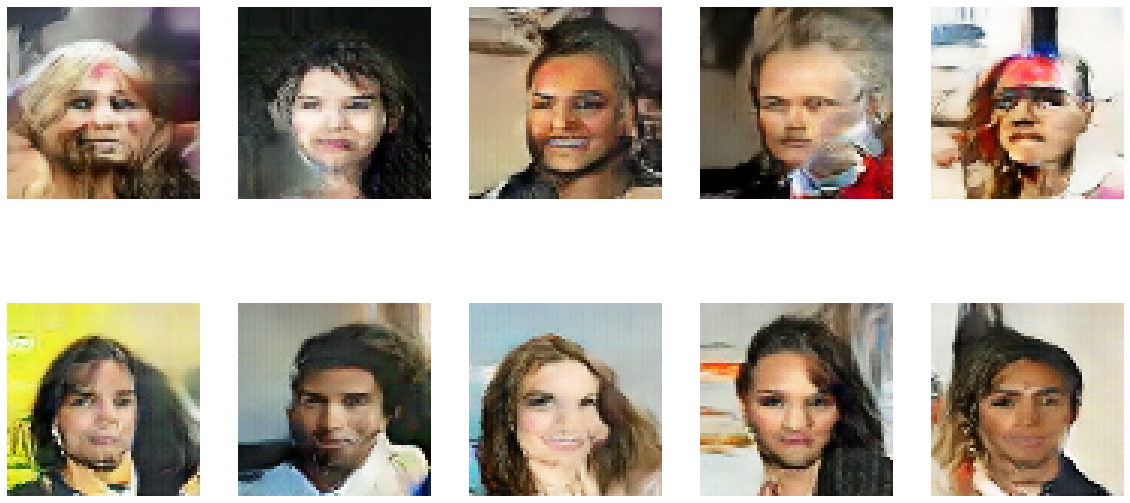

Epoch 44/50
6332/6332 [==============================] - 712s 112ms/step - d_loss: 0.5863 - g_loss: 1.0459


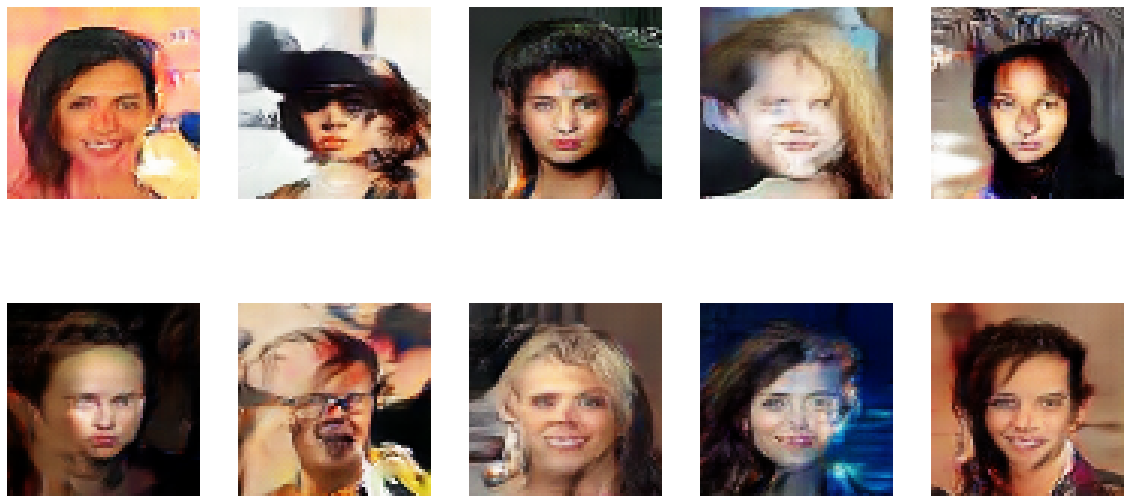

Epoch 45/50
6332/6332 [==============================] - 711s 112ms/step - d_loss: 0.5841 - g_loss: 1.0539


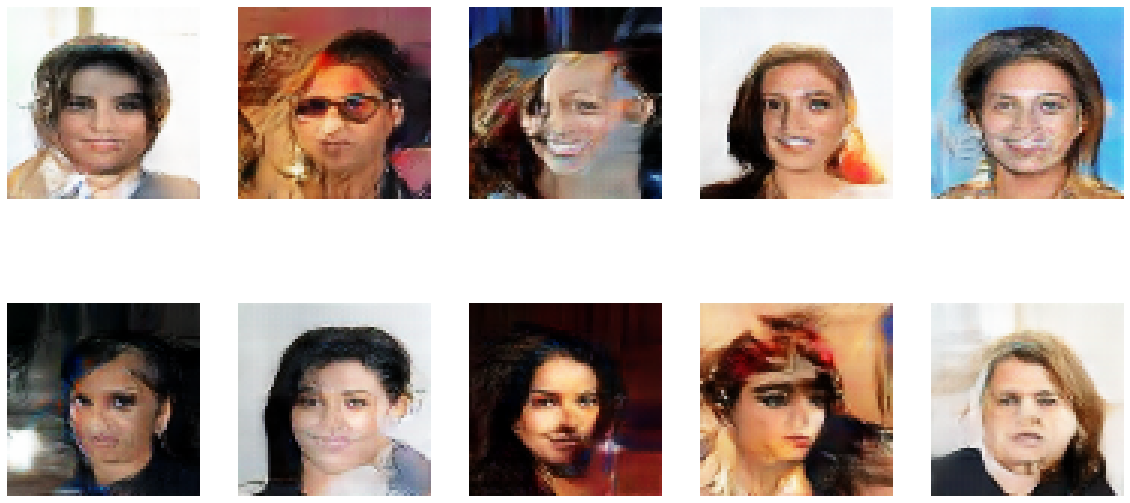

Epoch 46/50
6332/6332 [==============================] - 708s 112ms/step - d_loss: 0.5864 - g_loss: 1.0490


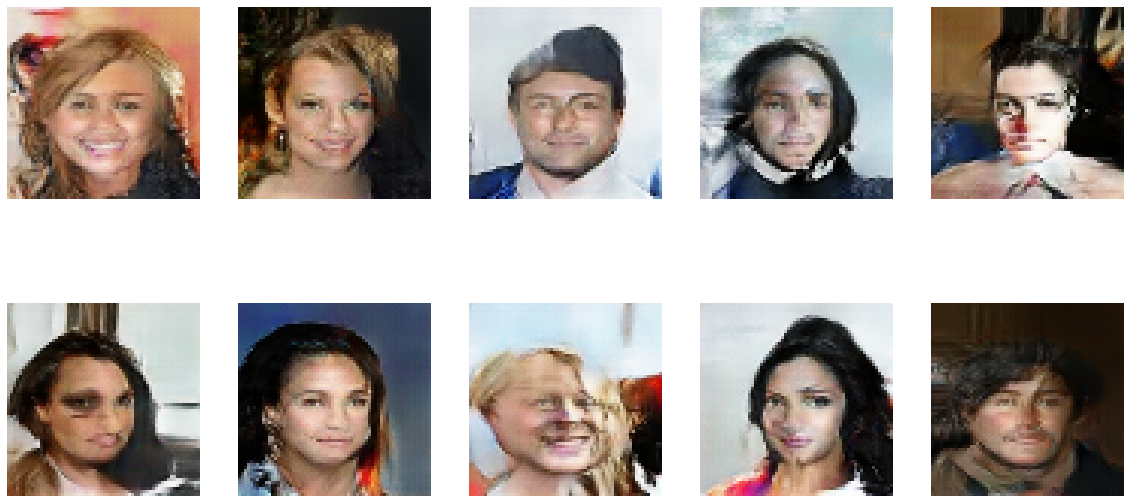

Epoch 47/50
6332/6332 [==============================] - 698s 110ms/step - d_loss: 0.5802 - g_loss: 1.0633


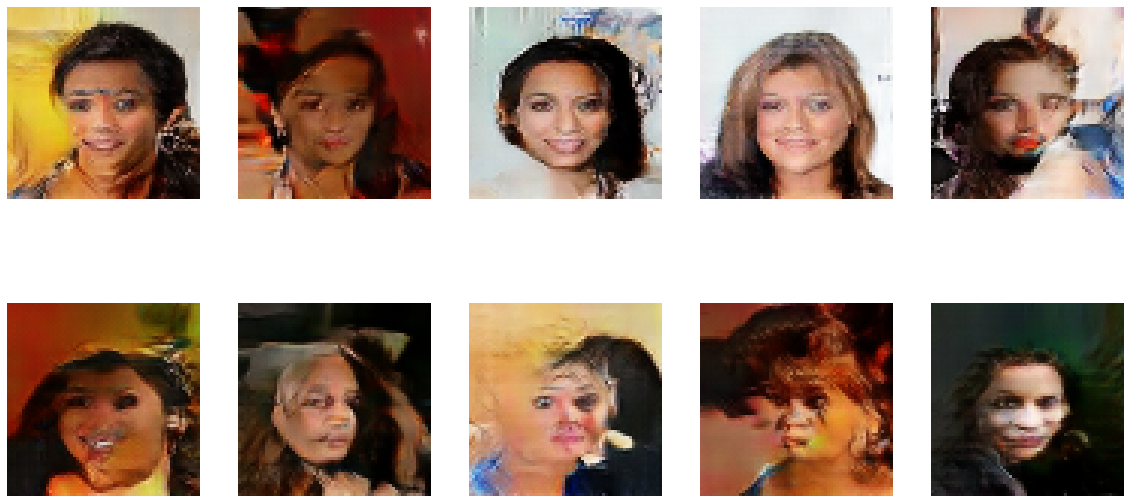

Epoch 48/50
6332/6332 [==============================] - 712s 112ms/step - d_loss: 0.5778 - g_loss: 1.0637


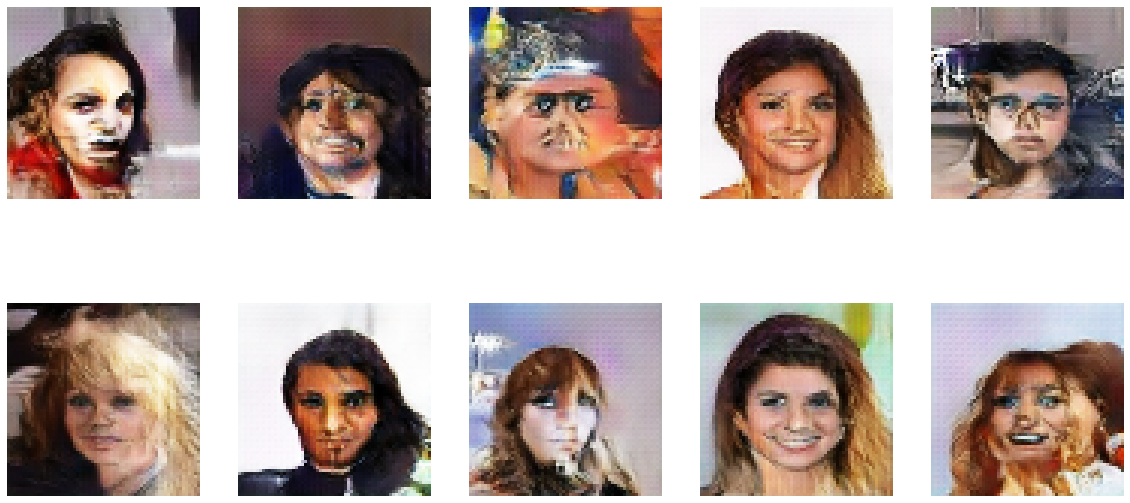

Epoch 49/50
6332/6332 [==============================] - 712s 112ms/step - d_loss: 0.5753 - g_loss: 1.0907


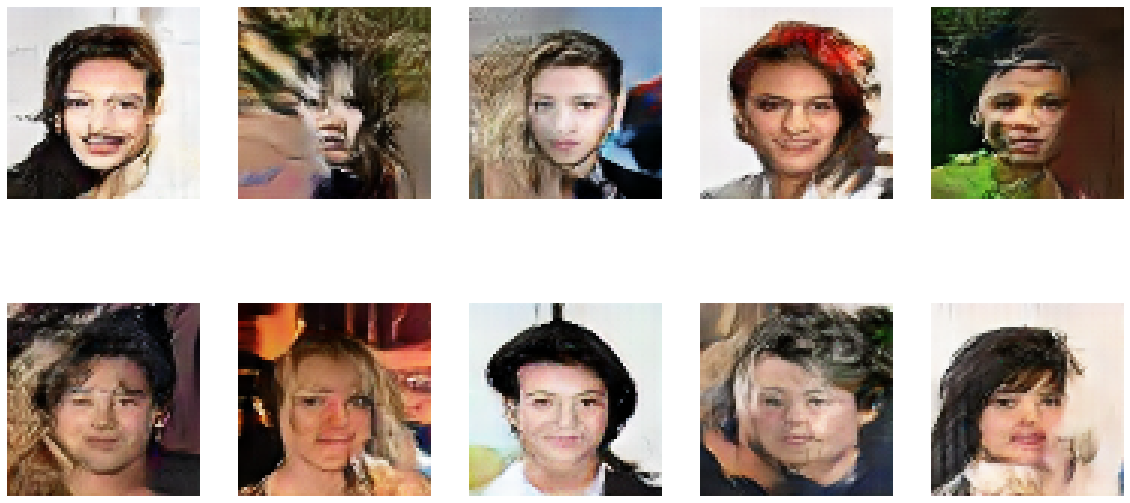

Epoch 50/50
6332/6332 [==============================] - 698s 110ms/step - d_loss: 0.5734 - g_loss: 1.0844


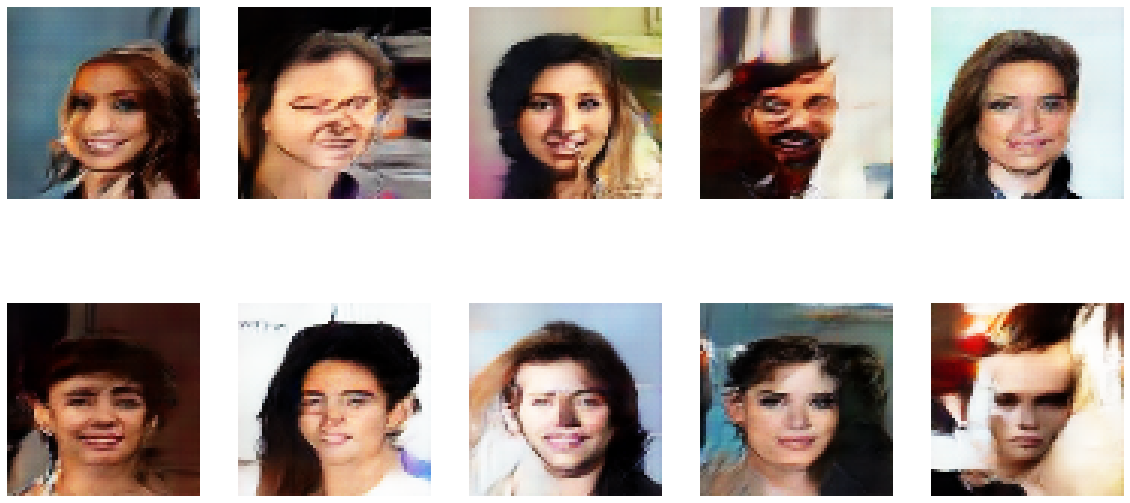

In [9]:
epochs = 50

gan = GAN(discriminator, generator, latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset,
    epochs=epochs,
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

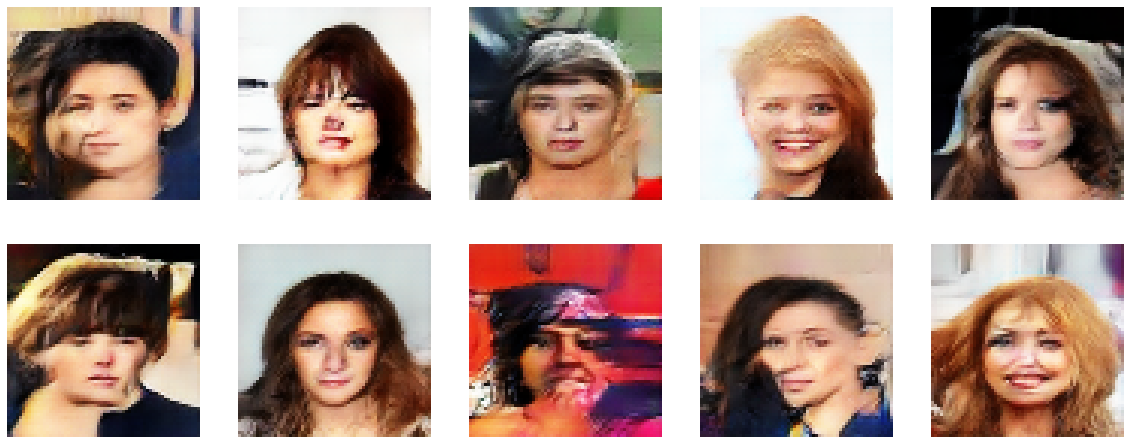

In [10]:
random_latent_vectors = tf.random.normal(shape=(10, 128))
generated_images = gan.generator(random_latent_vectors)
plt.figure(figsize=(20, 8))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.show()